In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
    
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [6]:
n_emd = 10
n_hidden = 200
vocab_size = 27

C = torch.randn((vocab_size, n_emd))
W1 = torch.randn((n_emd * block_size, n_hidden)) * (5/3) / ((n_emd * block_size)**0.5)
#b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]


for p in parameters:
    p.requires_grad = True

In [7]:
sum(p.nelement() for p in parameters)

12097

In [8]:
(5/3) / (30**0.5)

0.3042903097250923

tensor(-0.0116) tensor(0.9940)
tensor(-0.0005) tensor(0.9711)


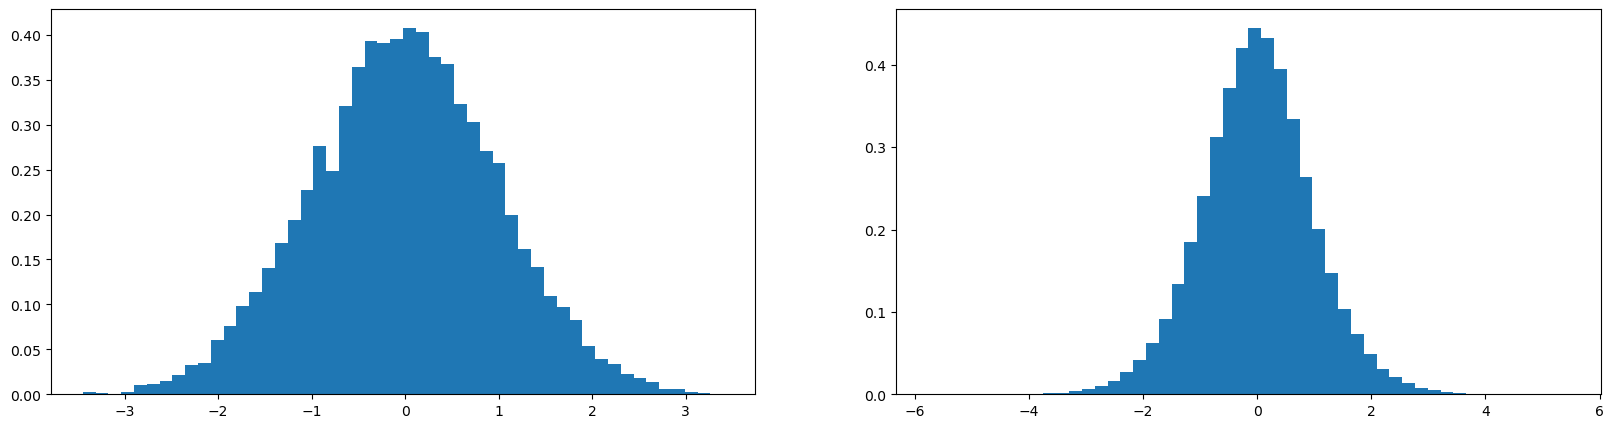

In [10]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121);
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122);
plt.hist(y.view(-1).tolist(), 50, density=True);

In [40]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 **lre

In [41]:
lri = []
lossi = []
stepi = []

In [42]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [43]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [44]:
print(bngain.grad)

None


In [57]:
max_steps = 10000
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    emb = C[Xtr[ix]]
    hpreact = emb.view(-1, 30) @ W1
    bnmeani= hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.mean(0, keepdim=True)
    hpreact = bngain * (hpreact - bnstdi) / bnmeani + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts/counts.sum(1, keepdims=True)
    # print(prob.shape)
    # loss = -prob[Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001* bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001* bnmeani
    
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad
    # lri.append(lre[i])
    # lossi.append(loss.item())
    if i % (1000) == 0:
        print(f'{i:7d}/{max_steps:7d} {loss.item():4f}')
    stepi.append(i)
    lossi.append(loss.item())
print(loss.log10().item())

      0/  10000 4.039172
   1000/  10000 2.583685
   2000/  10000 2.350640
   3000/  10000 2.359843
   4000/  10000 2.519392
   5000/  10000 2.162558
   6000/  10000 2.366834
   7000/  10000 2.415577
   8000/  10000 2.152433
   9000/  10000 2.091981
0.31001004576683044


(array([506., 470., 361., 322., 291., 294., 257., 254., 282., 236., 234.,
        267., 252., 216., 231., 240., 192., 172., 194., 186., 212., 199.,
        179., 182., 182., 196., 182., 184., 188., 186., 158., 185., 162.,
        178., 201., 222., 217., 252., 242., 267., 285., 240., 286., 309.,
        315., 293., 356., 344., 443., 498.]),
 array([-9.99913871e-01, -9.59920381e-01, -9.19926891e-01, -8.79933401e-01,
        -8.39939911e-01, -7.99946421e-01, -7.59952931e-01, -7.19959441e-01,
        -6.79965951e-01, -6.39972461e-01, -5.99978971e-01, -5.59985482e-01,
        -5.19991992e-01, -4.79998502e-01, -4.40005012e-01, -4.00011522e-01,
        -3.60018032e-01, -3.20024542e-01, -2.80031052e-01, -2.40037562e-01,
        -2.00044072e-01, -1.60050582e-01, -1.20057092e-01, -8.00636017e-02,
        -4.00701118e-02, -7.66217709e-05,  3.99168682e-02,  7.99103582e-02,
         1.19903848e-01,  1.59897338e-01,  1.99890828e-01,  2.39884318e-01,
         2.79877808e-01,  3.19871298e-01,  3.59864

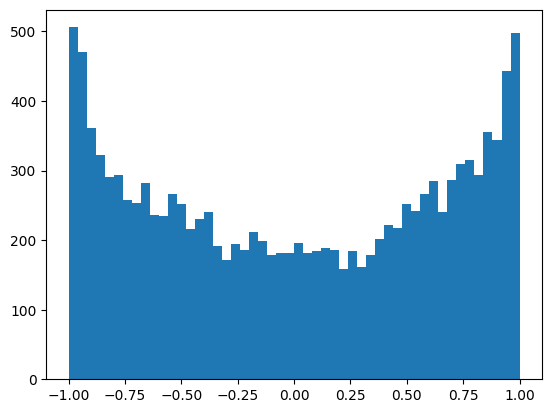

In [46]:
plt.hist(h.view(-1).tolist(), 50)

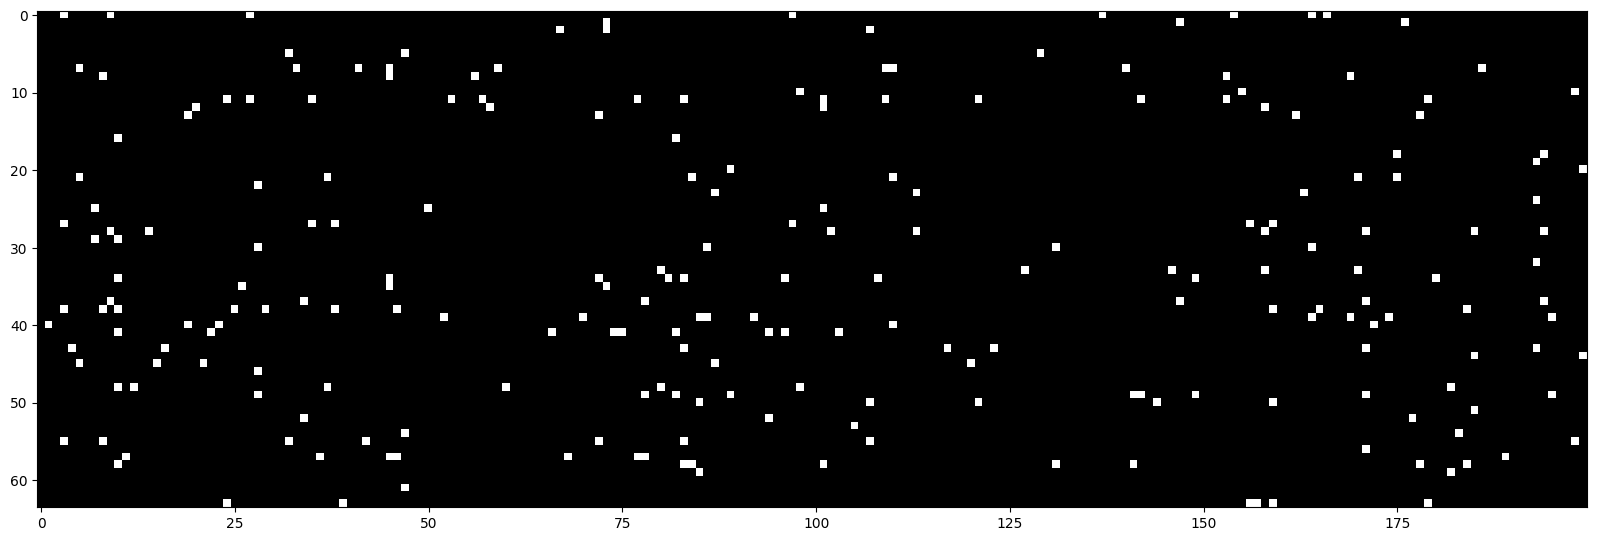

In [47]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
# trainning split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
plt.plot(lossi)

In [49]:
with torch.no_grad():

    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd =hpreact.std(0, keepdim=True)


In [50]:
bnmean.shape

torch.Size([1, 200])

In [58]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    hpreact = emb.view(-1, 30) @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')
    

train 2.2233221530914307
test 2.2455482482910156


In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
for _ in range(20):

    out = []
    context = [0] * 3
    while(True):
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))
print(C.shape)
C[torch.tensor(context)].shape